In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
import sys
sys.path.append('/g/data/x77/jj8842/')
sys.path.append('/g/data/x77/jj8842/results')
from naming_schema import *
import cosimagrace as cg
import default as df

In [3]:
t_ids = (14,15,0,1,2,3)

In [4]:
mm = 1/25.4
plt.figure()
plt.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 200

<Figure size 640x480 with 0 Axes>

In [5]:
def new_plot_transects(t):
    '''Plot as lines on a map where the transects are
    t = xarray object of transects'''
    
    
    for i in range(len(t.id)):
        l = np.zeros((2,2))
        l[0] = t.lon[i]
        l[1] = t.lat[i]
        
        if np.isnan(l[0,0]):
            l[0,0] = -1000
        
        if np.isnan(l[0,1]):
            l[0,1] = 1000

        if l[0,1]>l[0,0]:
            plt.plot(l[0],l[1],c='k',marker='|',markersize=10,linewidth=2)
        else:
            plt.plot((-1000,l[0,1]),l[1],c='k',marker='|',markersize=10,linewidth=2)
            plt.plot((l[0,0],1000),l[1],c='k',marker='|',markersize=10,linewidth=2)

In [6]:
#Copied from show mascon weights
def plot_mascon_data(transect_id, weights, data_version='', name_string = '', mascon_name = '', bathymetry = True, save_loc = '/g/data/x77/jj8842/',vlim = None,cbar_ax = None,roll=0):
    '''Plot the weights calculated in the linear regression so I can see the spacial distribution'''
    
    #weights = xr.load_dataset(save_loc+data_version+'/'+"{:02d}".format(int(transect_id))+'/'+name_string+'weights.nc').weights/1037/10**6
    plot_mascon = np.array(xr.load_dataset(save_loc+'mascon_definitions/plot_grid__'+mascon_name+'.nc').primary_mascon.roll(xt_ocean=-roll*10,roll_coords=True),int)
    xt_ocean = xr.load_dataset(save_loc+'mascon_definitions/plot_grid__'+mascon_name+'.nc').xt_ocean.roll(xt_ocean=-roll*10,roll_coords=True)
    xt_ocean = (xt_ocean-(-280+roll))%360+(-280+roll)
    yt_ocean = xr.load_dataset(save_loc+'mascon_definitions/plot_grid__'+mascon_name+'.nc').yt_ocean
    transect = xr.load_dataset(save_loc+data_version+'/transect_definitions.nc').sel(id = transect_id)
    
    full_weights = np.zeros(np.max(plot_mascon)+1)
    full_weights[:] = np.nan
    full_weights[weights.mc] = weights
    gridded_weights = full_weights[plot_mascon].T
    
    mascon_centres = xr.load_dataset(save_loc+'mascon_definitions/centres_'+mascon_name+'.nc').sel(mc=weights.mc)
    lons = np.array((np.min(mascon_centres.lons)-2,np.max(mascon_centres.lons)+2))
    lons[lons>80] = lons[lons>80]-360
    lats = np.array((np.min(mascon_centres.lats-2),np.max(mascon_centres.lats+2)))
    
    
    if vlim is None:
        vlim = np.max((np.max(weights),-np.min(weights)))
    c = plt.pcolormesh(xt_ocean,yt_ocean,gridded_weights,cmap='RdBu_r',vmin=-vlim,vmax = vlim,rasterized=True
                  )
    if transect_id == 14:
        if cbar_ax is None:
            cbar = plt.colorbar(c,extend='both')
        else:
            cbar = plt.colorbar(c,extend='both',ax=cbar_ax,fraction = 1)
        cbar.set_label('Ocean bottom pressure\n anomaly (dbar)')
        
    plt.xlim(lons)
    plt.ylim(lats)
    
    # bathymetry = cg.get_bathymetry()
    # local_bath = bathymetry.sel(xt_ocean = slice(lons[0],lons[1]),yt_ocean = slice(lats[0],lats[1]))
    # plt.contour(local_bath.xt_ocean,local_bath.yt_ocean,local_bath,np.arange(0,5000,1000),colors='k',linewidths=0.4,alpha=0.5)
    # c3000 = plt.contour(local_bath.xt_ocean,local_bath.yt_ocean,local_bath.where((local_bath.xt_ocean+local_bath.yt_ocean<-210) | (local_bath.xt_ocean<-175)),[3000],colors='k',linewidths=0.6)
    # labels = plt.gca().clabel(c3000,manual=((-177.8,-45),),fontsize=6,fmt={3000:'3000m'})
    # labels[0].set_bbox(dict(facecolor='white',edgecolor='None', alpha=0.5,boxstyle='round,pad=0.2'))
    # land = np.array(local_bath)
    # land[np.where(np.isnan(local_bath))] = -100
    # plt.contourf(local_bath.xt_ocean,local_bath.yt_ocean,land,(-200,0),colors='k')
    # plt.xlabel('longitude')
    # plt.ylabel('latitude')
    # plt.tight_layout()
    return c

14
15
0
1
2
3


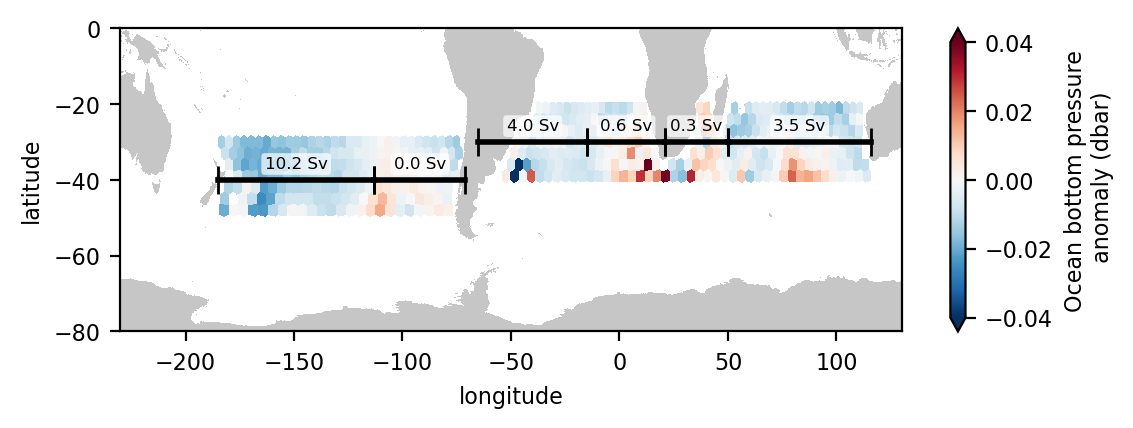

In [7]:
plt.figure(figsize=(160*mm,50*mm))
roll=50
bathymetry = cg.get_bathymetry().sel(yt_ocean = slice(-80,0))
land = np.isnan(bathymetry).roll(xt_ocean=-roll*10,roll_coords=True)
land.xt_ocean.data[land.xt_ocean<-280+roll]+=360
plt.pcolormesh(land.xt_ocean,land.yt_ocean,land,cmap='Greys',vmax=3,rasterized=True)

for t in t_ids:
    print(t)
    X,Y,w = cg.get_pbot_and_overturning(t,df.ACCESS_OM2_01, 'JPL', df.remove_climatology, 'data_v4',NS_extent=df.NS_extent,ocean_cutoff=df.ocean_cutoff)
    w = w-w.mean('time')
    plot_mascon_data(t,w.ewh.isel(time=300),'data_v4','','JPL',roll=roll,vlim=0.04)
    #Seems like there's a timeseries-long trend, stuff about halfway has a more even obp distribution

    folder = '/g/data/x77/jj8842/'+'data_v4'+"/{:02d}".format(int(t))+'/'
    overturning = xr.load_dataset(folder+df.ACCESS_OM2_01+'_hr_overturning.nc')['ty_trans_rho']/1037/10**6
    
    latm = df.transect.sel(id=np.array((t,))).lat.mean()+3
    shiftlon = (df.transect.sel(id=np.array((t,))).lon-(-280+roll))%360+(-280+roll)
    if shiftlon.diff('endpoint')>0:

        lonm = np.mean(shiftlon)
    else:
        lonm = shiftlon.isel(endpoint=1)-20

    plt.text(lonm,
                 latm,
                 str(np.round(overturning.mean().data,1))+' Sv',
             #fontweight='demi',
             fontsize=6,
             horizontalalignment = 'center',
             bbox = dict(facecolor='white',edgecolor='None', alpha=0.7,boxstyle='round,pad=0.2')
            )

#plt.title('Here are my transects, at an example time point, and the associated stuffs')

new_plot_transects((df.transect.sel(id=np.array(t_ids))-(-280+roll))%360+(-280+roll))
plt.xlim(-280+roll,80+roll)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.ylim(-80,0)
#plt.savefig('/g/data/x77/jj8842/results/images/paper_transect_diagram.pdf')

14
15
0
1
2
3


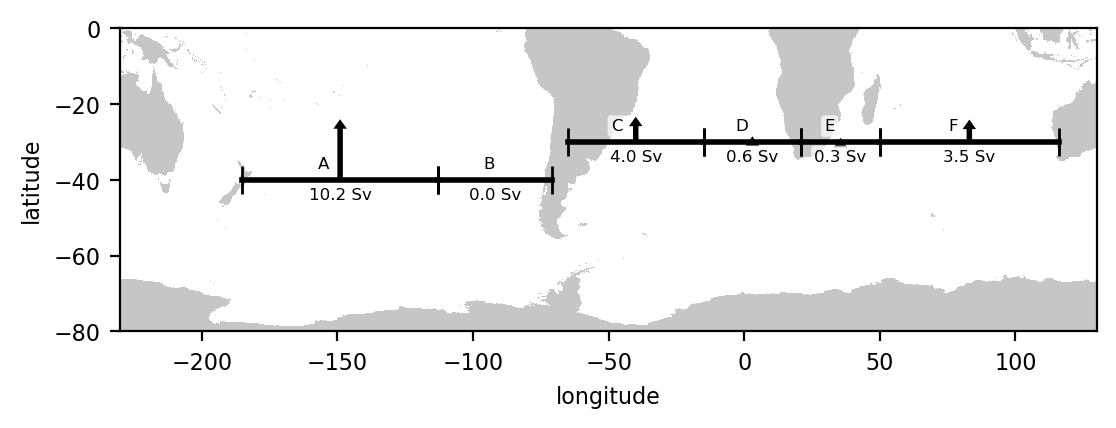

In [10]:
plt.figure(figsize=(160*mm,50*mm))
roll=50
bathymetry = cg.get_bathymetry().sel(yt_ocean = slice(-80,0))
land = np.isnan(bathymetry).roll(xt_ocean=-roll*10,roll_coords=True)
land.xt_ocean.data[land.xt_ocean<-280+roll]+=360
plt.pcolormesh(land.xt_ocean,land.yt_ocean,land,cmap='Greys',vmax=3,rasterized=True)
formal_labels = ('ABCDEF')
lon_label_shift = [-6,-2,-7,-4,-4,-6]

for i, t in enumerate(t_ids):
    #print(t)
    X,Y,w = cg.get_pbot_and_overturning(t,df.ACCESS_OM2_01, 'JPL', df.remove_climatology, 'data_v4',NS_extent=df.NS_extent,ocean_cutoff=df.ocean_cutoff)
    w = w-w.mean('time')
    #plot_mascon_data(t,w.ewh.isel(time=300),'data_v4','','JPL',roll=roll,vlim=0.04)
    #Seems like there's a timeseries-long trend, stuff about halfway has a more even obp distribution

    folder = '/g/data/x77/jj8842/'+'data_v4'+"/{:02d}".format(int(t))+'/'
    overturning = xr.load_dataset(folder+df.ACCESS_OM2_01+'_hr_overturning.nc')['ty_trans_rho']/1037/10**6
    
    latm = df.transect.sel(id=np.array((t,))).lat.mean()
    shiftlon = (df.transect.sel(id=np.array((t,))).lon-(-280+roll))%360+(-280+roll)
    ovt = overturning.mean().data
    if shiftlon.diff('endpoint')>0:

        lonm = np.mean(shiftlon)
    else:
        lonm = shiftlon.isel(endpoint=1)-20

    plt.text(lonm,
                 latm-5,
                 str(np.round(ovt,1))+' Sv',
             #fontweight='demi',
             fontsize=6,
             horizontalalignment = 'center',
             bbox = dict(facecolor='white',edgecolor='None', alpha=0.7,boxstyle='round,pad=0.2')
            )
    plt.text(lonm+lon_label_shift[i],
                 latm+3,
                 formal_labels[i],
             #fontweight='demi',
             fontsize=6,
             horizontalalignment = 'center',
             bbox = dict(facecolor='white',edgecolor='None', alpha=0.7,boxstyle='round,pad=0.2')
            )
    plt.arrow(lonm,latm,0,ovt*1.5,
              length_includes_head=True,
              color='k',
              width=1,
              head_width = 3,
              head_length=1.5,
             )

#plt.title('Here are my transects, at an example time point, and the associated stuffs')

new_plot_transects((df.transect.sel(id=np.array(t_ids))-(-280+roll))%360+(-280+roll))
plt.xlim(-280+roll,80+roll)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.ylim(-80,0)
plt.savefig('/g/data/x77/jj8842/results/images/paper_transect_diagram_bare.pdf')

### Plotting global weights

In [11]:
def plot_mascon_data2(transect_id, weights, data_version='', name_string = '', mascon_name = '', bathymetry = True, save_loc = '/g/data/x77/jj8842/',vlim = None,cbar_ax = None,roll=0):
    '''Plot the weights calculated in the linear regression so I can see the spacial distribution
    Copied from above; messing with the colorbar exclusively'''
    
    #weights = xr.load_dataset(save_loc+data_version+'/'+"{:02d}".format(int(transect_id))+'/'+name_string+'weights.nc').weights/1037/10**6
    plot_mascon = np.array(xr.load_dataset(save_loc+'mascon_definitions/plot_grid__'+mascon_name+'.nc').primary_mascon.roll(xt_ocean=-roll*10,roll_coords=True),int)
    xt_ocean = xr.load_dataset(save_loc+'mascon_definitions/plot_grid__'+mascon_name+'.nc').xt_ocean.roll(xt_ocean=-roll*10,roll_coords=True)
    xt_ocean = (xt_ocean-(-280+roll))%360+(-280+roll)
    yt_ocean = xr.load_dataset(save_loc+'mascon_definitions/plot_grid__'+mascon_name+'.nc').yt_ocean
    transect = xr.load_dataset(save_loc+data_version+'/transect_definitions.nc').sel(id = transect_id)
    
    full_weights = np.zeros(np.max(plot_mascon)+1)
    full_weights[:] = np.nan
    full_weights[weights.mc] = weights
    gridded_weights = full_weights[plot_mascon].T
    
    mascon_centres = xr.load_dataset(save_loc+'mascon_definitions/centres_'+mascon_name+'.nc').sel(mc=weights.mc)
    mascon_centres.lons.data[mascon_centres.lons<-280+roll]+=360
    mascon_centres.lons.data[mascon_centres.lons>80+roll]-=360
    
    lons = np.array((np.min(mascon_centres.lons)-2,np.max(mascon_centres.lons)+2))
    if lons[1]<lons[0]:
        temp = lons[0]
        lons[0] = lons[1]
        lons[1] = temp
    lats = np.array((np.min(mascon_centres.lats-2),np.max(mascon_centres.lats+2)))
    
    
    
    if vlim is None:
        vlim = np.max((np.max(weights),-np.min(weights)))
    c = plt.pcolormesh(xt_ocean,yt_ocean,gridded_weights,cmap='RdBu_r',vmin=-vlim,vmax = vlim,rasterized=True
                  )
    plt.xlim(lons)
    plt.ylim(lats)

    bathymetry = cg.get_bathymetry().coarsen(xt_ocean=5,yt_ocean=5).mean()
    bathymetry =bathymetry.roll(xt_ocean=-roll*2,roll_coords=True)
    bathymetry.xt_ocean.data[bathymetry.xt_ocean<-280+roll]+=360
    bathymetry.xt_ocean.data[bathymetry.xt_ocean>80+roll]-=360
    print('-------------')
    print(lons)
    print(float(np.min(bathymetry.xt_ocean)),float(np.max(bathymetry.xt_ocean)))
    local_bath = bathymetry.sel(xt_ocean = slice(lons[0],lons[1]),yt_ocean = slice(lats[0],lats[1]))
    
    
    c3000 = plt.contour(local_bath.xt_ocean,local_bath.yt_ocean,local_bath,[3000],colors='#555555',linewidths=1)

    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.tight_layout()
    return c

In [9]:
save_loc = '/g/data/x77/jj8842/'
mascon_name='JPL'
data_version='data_v4'

/jobfs/120844489.gadi-pbs/ipykernel_1458530/1087303869.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = plt.pcolormesh(xt_ocean,yt_ocean,gridded_weights,cmap='RdBu_r',vmin=-vlim,vmax = vlim,rasterized=True


-------------
[-186.5 -111.5]
-229.74999999999605 129.75000000000395


/jobfs/120844489.gadi-pbs/ipykernel_1458530/1087303869.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = plt.pcolormesh(xt_ocean,yt_ocean,gridded_weights,cmap='RdBu_r',vmin=-vlim,vmax = vlim,rasterized=True


-------------
[-114.5  -70.5]
-229.74999999999605 129.75000000000395


/jobfs/120844489.gadi-pbs/ipykernel_1458530/1087303869.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = plt.pcolormesh(xt_ocean,yt_ocean,gridded_weights,cmap='RdBu_r',vmin=-vlim,vmax = vlim,rasterized=True


-------------
[-61.5 -13.5]
-229.74999999999605 129.75000000000395


/jobfs/120844489.gadi-pbs/ipykernel_1458530/1087303869.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = plt.pcolormesh(xt_ocean,yt_ocean,gridded_weights,cmap='RdBu_r',vmin=-vlim,vmax = vlim,rasterized=True


-------------
[-16.5  22.5]
-229.74999999999605 129.75000000000395


/jobfs/120844489.gadi-pbs/ipykernel_1458530/1087303869.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = plt.pcolormesh(xt_ocean,yt_ocean,gridded_weights,cmap='RdBu_r',vmin=-vlim,vmax = vlim,rasterized=True


-------------
[19.5 51.5]
-229.74999999999605 129.75000000000395


/jobfs/120844489.gadi-pbs/ipykernel_1458530/1087303869.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = plt.pcolormesh(xt_ocean,yt_ocean,gridded_weights,cmap='RdBu_r',vmin=-vlim,vmax = vlim,rasterized=True


-------------
[ 48.5 117.5]
-229.74999999999605 129.75000000000395
-------------
[-185.5 -111.2]
-229.74999999999605 129.75000000000395
-------------
[-113.24  -71.8 ]
-229.74999999999605 129.75000000000395
-------------
[-54.26 -13.28]
-229.74999999999605 129.75000000000395
-------------
[-16.86  19.42]
-229.74999999999605 129.75000000000395
-------------
[19.29 51.25]
-229.74999999999605 129.75000000000395
-------------
[ 48.1  116.19]
-229.74999999999605 129.75000000000395
-------------
[-185.5 -111.2]
-229.74999999999605 129.75000000000395
-------------
[-113.24  -71.8 ]
-229.74999999999605 129.75000000000395
-------------
[-54.26 -13.28]
-229.74999999999605 129.75000000000395
-------------
[-16.86  19.42]
-229.74999999999605 129.75000000000395
-------------
[19.29 51.25]
-229.74999999999605 129.75000000000395
-------------
[ 48.1  116.19]
-229.74999999999605 129.75000000000395
CPU times: user 25.7 s, sys: 5.65 s, total: 31.4 s
Wall time: 31.5 s


Text(0.0, 1.0, 'c) weights for JPL mascons with noise')

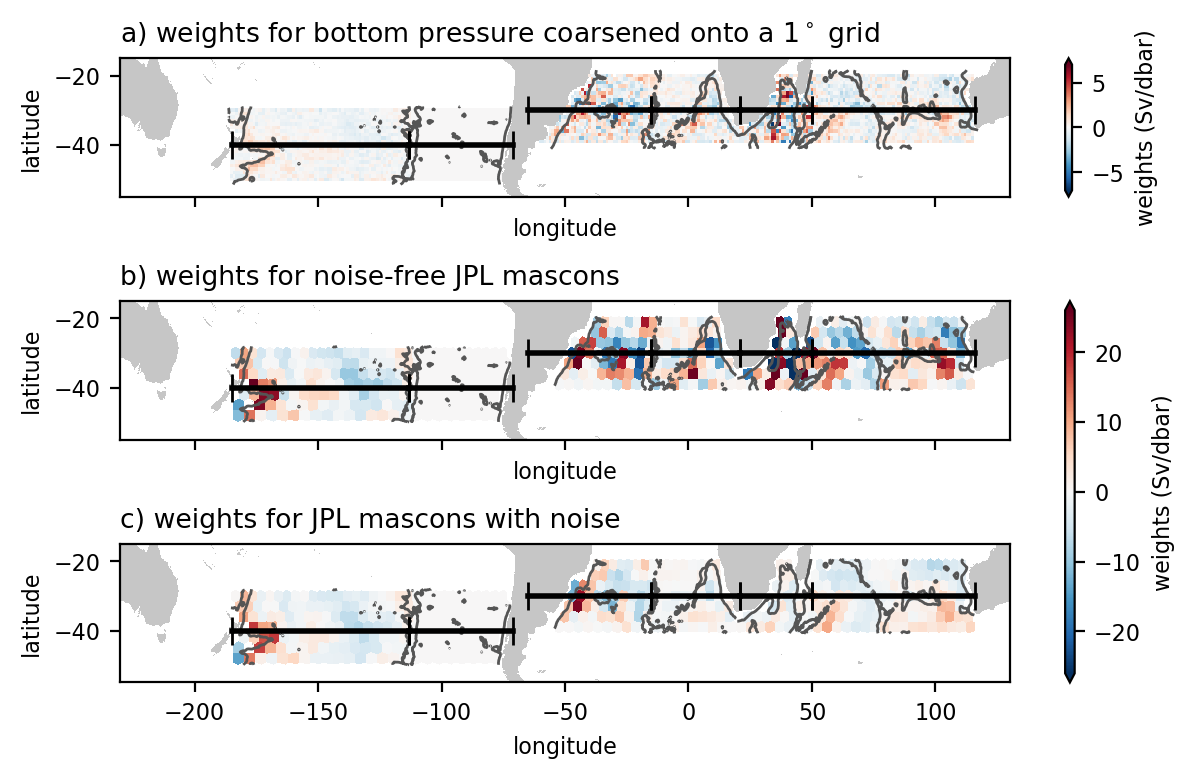

In [13]:
%%time
fig, axs = plt.subplots(3,1,figsize=(160*mm,100*mm),sharex=True)
plt.subplots_adjust(hspace=0.5)
roll=50
bathymetry = cg.get_bathymetry().sel(yt_ocean = slice(-80,0))
land = np.isnan(bathymetry).roll(xt_ocean=-roll*10,roll_coords=True)
land.xt_ocean.data[land.xt_ocean<-280+roll]+=360

plt.sca(axs[0])
plt.pcolormesh(land.xt_ocean,land.yt_ocean,land,cmap='Greys',vmax=3,rasterized=True)
for t in t_ids:
    weights = xr.load_dataset(save_loc+data_version+'/'+"{:02d}".format(int(t))+'/paper/1deg_weights.nc').weights/1037/10**6

    c = plot_mascon_data2(t,weights,'data_v4','','ACCESS_1deg',roll=roll,vlim=7)
    
new_plot_transects((df.transect.sel(id=np.array(t_ids))-(-280+roll))%360+(-280+roll))

plt.xlim(-280+roll,80+roll)
plt.ylabel('latitude')
plt.ylim(-55,-15)
plt.title('a) weights for bottom pressure coarsened onto a 1$^\circ$ grid',loc='left')
fig.colorbar(c,ax=axs[0],orientation='vertical',extend='both',
             label='weights (Sv/dbar)')


plt.sca(axs[1])
plt.pcolormesh(land.xt_ocean,land.yt_ocean,land,cmap='Greys',vmax=3,rasterized=True)
for t in t_ids:
    weights = xr.load_dataset(save_loc+data_version+'/'+"{:02d}".format(int(t))+'/paper/JPL_weights.nc').weights/1037/10**6

    plot_mascon_data2(t,weights,'data_v4','','JPL',roll=roll,vlim=26)
    
new_plot_transects((df.transect.sel(id=np.array(t_ids))-(-280+roll))%360+(-280+roll))
plt.xlim(-280+roll,80+roll)
plt.ylabel('latitude')
plt.ylim(-55,-15)
plt.title('b) weights for noise-free JPL mascons',loc='left')

plt.sca(axs[2])
plt.pcolormesh(land.xt_ocean,land.yt_ocean,land,cmap='Greys',vmax=3,rasterized=True)

for t in t_ids:
    weights = xr.load_dataset(save_loc+data_version+'/'+"{:02d}".format(int(t))+'/paper/JPL_noisy_weights.nc').weights/1037/10**6

    c = plot_mascon_data2(t,weights,'data_v4','','JPL',roll=roll,vlim=26)
    
new_plot_transects((df.transect.sel(id=np.array(t_ids))-(-280+roll))%360+(-280+roll))
plt.xlim(-280+roll,80+roll)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.ylim(-55,-15)
fig.colorbar(c,ax=axs[1:],orientation='vertical',extend='both',
             label='weights (Sv/dbar)',aspect=40,
             extendfrac=0.025)
plt.title('c) weights for JPL mascons with noise',loc='left')

plt.savefig('/g/data/x77/jj8842/results/images/hr_weights_globally_contoured.pdf')

hi


361.0